In [1]:
import os
import json
import subprocess
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from os.path import join as pjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from nilearn.glm.first_level import make_first_level_design_matrix

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# define path
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'
fmriprep_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/fmriprep'
ciftify_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/ciftify'
nifti_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/nifti'

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [23]:
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

def roi_mask(roi_name):
    """
        roi_name : list or str
    """
    # load reference info
    main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
    roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
    roi_names = pd.read_csv(roi_name_path)
    roi = sio.loadmat(pjoin(main_path, 'MMP_mpmLR32k.mat'))['glasser_MMP']  # 1x59412

    # start load name
    roi_index = []
    if isinstance(roi_name, str):
        roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{roi_name}_ROI']).any(axis=1)].index[0]+1
        roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    else:
        for name in roi_name:
            roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{name}_ROI']).any(axis=1)].index[0]+1
            roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    return mask

# define path
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'

Early_name = ['V1', 'V2', 'V3', 'V4']
Ventral_name = ['V8', 'PIT', 'FFC', 'VVC', 'VMV1', 'VMV2', 'VMV3']
MT_name = ['V3CD', 'V4t', 'LO1', 'LO2', 'LO3', 'FST', 'MST', 'MT', 'PH']
Dorsal_name = ['V3A', 'V3B', 'V6', 'V6A', 'V7', 'IPS1']
AIP_name = ['1', '2', '3a', '3b']
# VPM_name = ['6r', 'IFJp', 'IFJa', 'IFSp', '44']

roi_sum = ['Early', 'Ventral', 'MT', 'Dorsal', 'AIP']
for roi in roi_sum:
    exec(f'{roi}_mask = roi_mask({roi}_name)')
    print(eval(f'{roi}_mask').sum())


4193
1244
1349
1140
3736


#### Correlation distance across subjects. Here distinguishes same or different categories.
##### In this section, beta used are in the whole session model.

In [4]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

# Load beta for 30 subjects 
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub')])

mask_sum = ['EVC', 'DS', 'VTC', 'MT', 'AIP']

corr_same_sum = np.zeros((2, len(mask_sum)))
corr_diff_sum = np.zeros((2, len(mask_sum)))

n_sub = len(sub_names)
n_class = 180

beta_sum = np.zeros((n_sub, n_class, 59412))
for sub_idx, sub_name in enumerate(sub_names):
    # define beta path
    beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-beta_clean.npy')
    beta_sub = np.load(beta_sub_path)
    scaler = StandardScaler()
    beta_sum[sub_idx] = scaler.fit_transform(beta_sub)

for mask_idx, mask_name in enumerate(mask_sum):
    mask = eval(f'{mask_name}_mask')
    beta_mask = beta_sum[:, :, mask]
    # compute correlation for same image
    corr_vector = np.zeros((n_class, int(n_sub*(n_sub-1)/2)))
    for image_idx in range(n_class):
        image_pattern = beta_mask[:, image_idx, :]
        # corr_matrix = np.corrcoef(image_pattern)
        # corr_triu = corr_matrix[np.triu(corr_matrix, k=1)!=0]
        corr_triu = pdist(image_pattern, 'correlation')
        corr_vector[image_idx] = corr_triu
    print('%s same image distance: %.3f'%(mask_name, corr_vector.mean()))
    corr_same_sum[0, mask_idx] = corr_vector.mean()
    corr_same_sum[1, mask_idx] = np.sqrt(corr_vector.std()/(n_class*int(n_sub*(n_sub-1)/2)))

    # compute correlation for different image
    corr_vector = np.zeros((n_class, n_class-1, int(n_sub*n_sub)))
    for image_idx_first in range(n_class):
        image_leave = np.delete(np.arange(n_class), image_idx_first)
        for idx, image_idx_second in enumerate(image_leave):
            # corr_matrix = np.corrcoef(beta_mask[:, image_idx_first, :], beta_mask[:, image_idx_second, :])[:n_sub, n_sub:]
            corr_matrix = pairwise_distances(beta_mask[:, image_idx_first, :], beta_mask[:, image_idx_second, :], metric='correlation')
            corr_vector[image_idx_first, idx] = corr_matrix.flatten()
    print('%s different image distance: %.3f'%(mask_name, corr_vector.mean()))
    corr_diff_sum[0, mask_idx] = corr_vector.mean()
    corr_diff_sum[1, mask_idx] = np.sqrt(corr_vector.std()/(n_class*(n_class-1)*n_sub*n_sub))


EVC same image distance: 0.984
EVC different image distance: 1.000
DS same image distance: 0.978
DS different image distance: 1.000
VTC same image distance: 0.976
VTC different image distance: 1.000
MT same image distance: 0.957
MT different image distance: 1.000
AIP same image distance: 0.974
AIP different image distance: 1.000


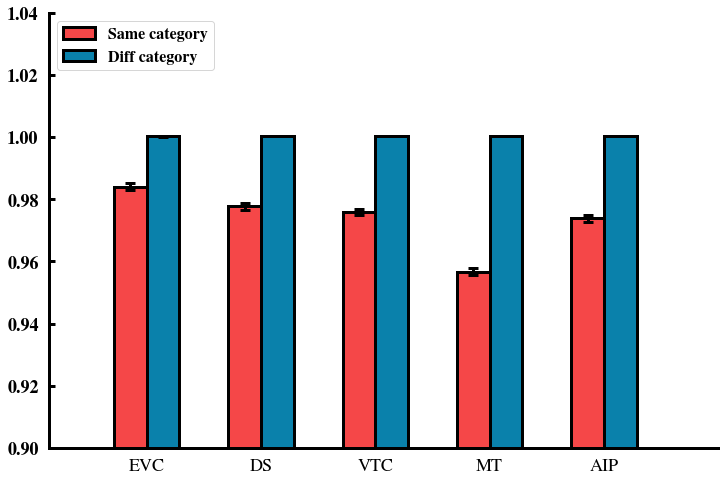

In [6]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import join as pjoin
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

corr_within_mean = corr_same_sum[0, :]
corr_within_std = corr_same_sum[1, :]
corr_between_mean = corr_diff_sum[0, :]
corr_between_std = corr_diff_sum[1, :]

width = 0.2
labels = mask_sum
x_1 = 0.7*np.arange(corr_within_mean.shape[0])
x_2 = x_1 + width

plt.figure(figsize=(12, 8))
plt.bar(x_1, corr_within_mean, yerr=corr_within_std, label='Same category', color='#F54748', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")
plt.bar(x_2, corr_between_mean, yerr=corr_between_std, label='Diff category', color='#0A81AB', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
# ax.set_ylabel('Pattern Correlation', weight='bold', size=20, label)
ax.tick_params(labelsize=18, width=3, length=6, direction="in", pad=10)

plt.xticks((x_1 + x_2)/2, labels, weight='bold', fontsize=20)
plt.yticks(weight='bold')
plt.legend(loc='upper left', prop={'size':16, 'weight':'bold'})

ax.set_ylim(0.9, 1.04)
ax.set_xlim(-0.5, 3.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_position(('data', 0.9))
ax.spines['left'].set_linewidth(3)

#### Correlation distance within subjects. In each subjects, each categories are presented 4 times. Here distinguishes same or different categories.
##### In this section, beta used are in the three-run model, which means three will be 180x4 beta for each subject.

In [3]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

# Load beta for 30 subjects 
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub') and int(i.split('-')[-1])<=30])

mask_sum = ['EVC', 'DS', 'VTC', 'MT', 'AIP']

corr_same_sum = np.zeros((len(sub_names), 2, len(mask_sum)))
corr_diff_sum = np.zeros((len(sub_names), 2, len(mask_sum)))

n_sub = len(sub_names)
n_class = 180
n_sess = 4

for sub_idx, sub_name in enumerate(sub_names):
    # define beta path
    beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-beta_clean_split.npy')
    beta_sub = np.load(beta_sub_path)
    for sess_idx in range(n_sess):
        scaler = StandardScaler()
        beta_sub[sess_idx] = scaler.fit_transform(beta_sub[sess_idx])

    for mask_idx, mask_name in enumerate(mask_sum):
        mask = eval(f'{mask_name}_mask')
        beta_mask = beta_sub[:, :, mask]
        # compute correlation for same image
        corr_vector = np.zeros((n_class, int(n_sess*(n_sess-1)/2)))
        for image_idx in range(n_class):
            image_pattern = beta_mask[:, image_idx, :]
            # corr_matrix = np.corrcoef(image_pattern)
            # corr_triu = corr_matrix[np.triu(corr_matrix, k=1)!=0]
            corr_triu = pdist(image_pattern, 'correlation')
            corr_vector[image_idx] = corr_triu
        corr_same_sum[sub_idx, 0, mask_idx] = corr_vector.mean()
        corr_same_sum[sub_idx, 1, mask_idx] = np.sqrt(corr_vector.std()/(n_class*int(n_sess*(n_sess-1)/2)))

        # compute correlation for different image
        corr_vector = np.zeros((n_class, n_class-1, int(n_sess*n_sess)))
        for image_idx_first in range(n_class):
            image_leave = np.delete(np.arange(n_class), image_idx_first)
            for idx, image_idx_second in enumerate(image_leave):
                # corr_matrix = np.corrcoef(beta_mask[:, image_idx_first, :], beta_mask[:, image_idx_second, :])[:n_sub, n_sub:]
                corr_matrix = pairwise_distances(beta_mask[:, image_idx_first, :], beta_mask[:, image_idx_second, :], metric='correlation')
                corr_vector[image_idx_first, idx] = corr_matrix.flatten()
        corr_diff_sum[sub_idx, 0, mask_idx] = corr_vector.mean()
        corr_diff_sum[sub_idx, 1, mask_idx] = np.sqrt(corr_vector.std()/(n_class*(n_class-1)*n_sess*n_sess))
    print(f'Finish {sub_name}')
corr_same_sum = corr_same_sum.mean(axis=0)
corr_diff_sum = corr_diff_sum.mean(axis=0)


Finish sub-01
Finish sub-02
Finish sub-03
Finish sub-04
Finish sub-05
Finish sub-06
Finish sub-07
Finish sub-08
Finish sub-09
Finish sub-10
Finish sub-11
Finish sub-12
Finish sub-13
Finish sub-14
Finish sub-15
Finish sub-16
Finish sub-17
Finish sub-18
Finish sub-19
Finish sub-20
Finish sub-21
Finish sub-22
Finish sub-23
Finish sub-24
Finish sub-25
Finish sub-26
Finish sub-27
Finish sub-28
Finish sub-29
Finish sub-30


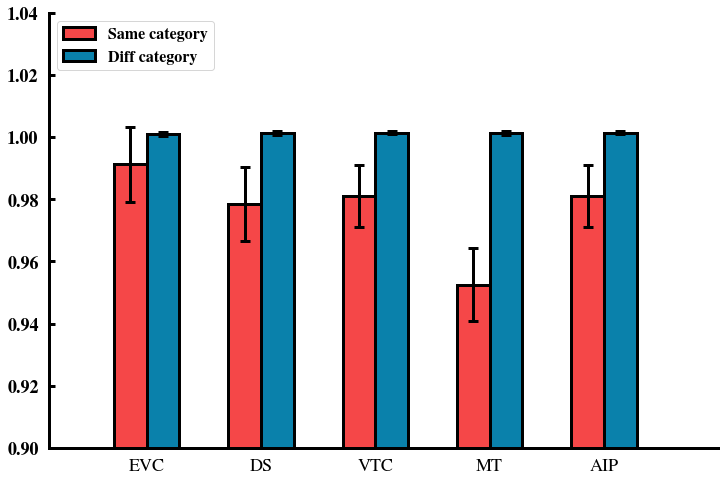

In [4]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import join as pjoin
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

corr_within_mean = corr_same_sum[0, :]
corr_within_std = corr_same_sum[1, :]
corr_between_mean = corr_diff_sum[0, :]
corr_between_std = corr_diff_sum[1, :]

width = 0.2
labels = mask_sum
x_1 = 0.7*np.arange(corr_within_mean.shape[0])
x_2 = x_1 + width

plt.figure(figsize=(12, 8))
plt.bar(x_1, corr_within_mean, yerr=corr_within_std, label='Same category', color='#F54748', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")
plt.bar(x_2, corr_between_mean, yerr=corr_between_std, label='Diff category', color='#0A81AB', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
# ax.set_ylabel('Pattern Correlation', weight='bold', size=20, label)
ax.tick_params(labelsize=18, width=3, length=6, direction="in", pad=10)

plt.xticks((x_1 + x_2)/2, labels, weight='bold', fontsize=20)
plt.yticks(weight='bold')
plt.legend(loc='upper left', prop={'size':16, 'weight':'bold'})

ax.set_ylim(0.9, 1.04)
ax.set_xlim(-0.5, 3.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_position(('data', 0.9))
ax.spines['left'].set_linewidth(3)

#### ISC part
##### Voxel-wise correlation of 180x1 category response between subjects. We use leave-one-out strategy here to compute ISC

In [3]:
from scipy.stats import pearsonr

# generate surface map for tSNR
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    if len(data.shape) > 1:
        ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    else:
        ex_cii.header.get_index_map(0).number_of_series_points = 1
        data = data[np.newaxis, :]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

# Load beta for 30 subjects 
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub')])
result_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/result/brain_map'
n_sub = len(sub_names)
n_class = 180
beta_sum = np.zeros((n_sub, n_class, 59412))
for sub_idx, sub_name in enumerate(sub_names):
    # define beta path
    beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-beta_clean.npy')
    beta_sub = np.load(beta_sub_path)
    scaler = StandardScaler()
    beta_sum[sub_idx] = scaler.fit_transform(beta_sub)
    print('Finish load data:%s'%sub_name)

isc_path = pjoin(result_path, f'isc.dtseries.nii')
if not os.path.exists(isc_path):
    isc_map = np.zeros((n_sub, 59412))
    for voxel_idx in range(beta_sum.shape[-1]):
        voxel_pattern = beta_sum[:, :, voxel_idx]
        # ISC was computed by correlation of each per participant with the mean pattern of remaining n-1 participants
        for sub_idx in range(n_sub):
            target_pattern = voxel_pattern[sub_idx]
            mean_pattern = voxel_pattern[np.delete(np.arange(n_sub), sub_idx)].mean(axis=0)
            isc_map[sub_idx, voxel_idx] = pearsonr(target_pattern, mean_pattern)[0]
        print('Finish voxel:%05d'%voxel_idx)
    isc_map = isc_map.mean(axis=0)
    # save isc map
    isc_map_save = np.zeros((91282))
    isc_map_save[:59412] = isc_map
    save_ciftifile(isc_map_save, pjoin(result_path, f'isc.dtseries.nii'))
else:
    isc_map = np.array(nib.load(isc_path).get_fdata().tolist()).squeeze()[:59412]


Finish load data:sub-01
Finish load data:sub-02
Finish load data:sub-03
Finish load data:sub-04
Finish load data:sub-05
Finish load data:sub-06
Finish load data:sub-07
Finish load data:sub-08
Finish load data:sub-09
Finish load data:sub-10
Finish load data:sub-11
Finish load data:sub-12
Finish load data:sub-13
Finish load data:sub-14
Finish load data:sub-15
Finish load data:sub-16
Finish load data:sub-17
Finish load data:sub-18
Finish load data:sub-19
Finish load data:sub-20
Finish load data:sub-21
Finish load data:sub-22
Finish load data:sub-23
Finish load data:sub-24
Finish load data:sub-25
Finish load data:sub-26
Finish load data:sub-27
Finish load data:sub-28
Finish load data:sub-29
Finish load data:sub-30


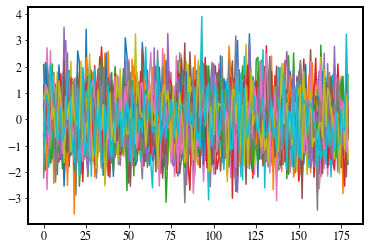

In [25]:
voxel = 15389
voxel_beta = beta_sum[:, :, voxel]
for sub_idx in range(n_sub):
    plt.plot(voxel_beta[sub_idx, :])


(array([  538., 12141., 22300., 10050.,  6513.,  4093.,  2344.,  1006.,
          366.,    61.]),
 array([-0.0694614 , -0.02986984,  0.00972172,  0.04931329,  0.08890485,
         0.12849641,  0.16808798,  0.20767954,  0.2472711 ,  0.28686267,
         0.32645423]),
 <BarContainer object of 10 artists>)

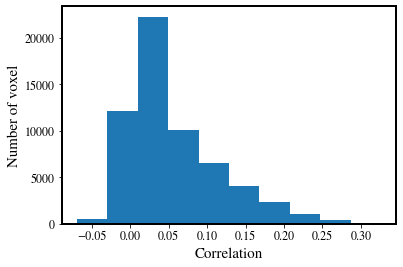

In [12]:
plt.xlabel('Correlation', size=15)
plt.ylabel('Number of voxel', size=15)
plt.hist(isc_map)

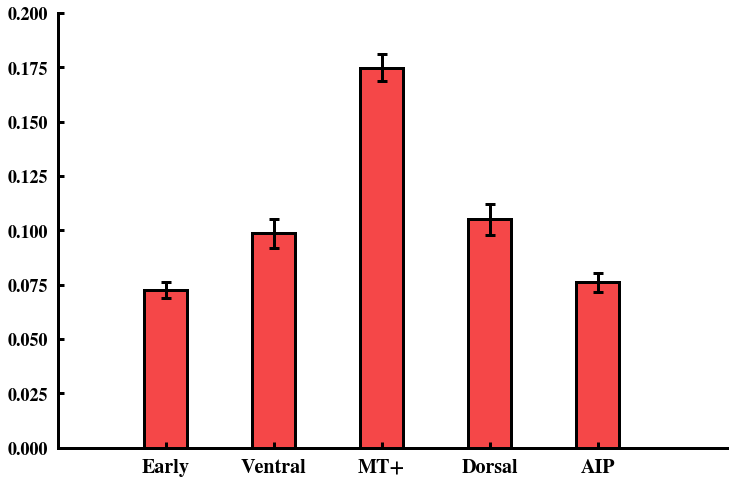

In [24]:

# bar plot of specified ROI: ISC mean and std
isc_roi = np.zeros((2, len(roi_sum)))
roi_sum = ['Early', 'Ventral', 'MT', 'Dorsal', 'AIP']
for roi_idx, roi in enumerate(roi_sum):
    tmp_mask = roi_mask(eval(f'{roi}_name'))
    isc_roi[0, roi_idx] = isc_map[tmp_mask].mean()
    isc_roi[1, roi_idx] = np.sqrt(isc_map[tmp_mask].std()/tmp_mask.sum())

width = 0.2
labels = [x+'+' if x =='MT' else x for x in roi_sum]
x_1 = 0.5*np.arange(len(roi_sum))

plt.figure(figsize=(12, 8))
plt.bar(x_1, isc_roi[0], yerr=isc_roi[1], color='#F54748', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
# ax.set_ylabel('Pattern Correlation', weight='bold', size=20, label)
ax.tick_params(labelsize=18, width=3, length=6, direction="in", pad=10)

plt.xticks(x_1, labels, weight='bold', fontsize=20)
plt.yticks(weight='bold')
# plt.legend(loc='upper left', prop={'size':16, 'weight':'bold'})

ax.set_ylim(0, 0.2)
ax.set_xlim(-0.5, 2.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
# ax.spines['bottom'].set_position(('data', 0.9))
ax.spines['left'].set_linewidth(3)